# Market Regime Forecasting with ARIMA

The use of ARIMA and its variant SARIMA was found to be largely a futile exercise. While it produces very accurate forecasting in-sample during the training period, it failed to yield any meaningful results out-of-sample during the test period. For this reason, no backtesting was done for this strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from warnings import simplefilter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.special import expit, logit

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Enter ticker symbol here
ticker = 'SPY'


# Read ticker_markov.csv data for ticker
filepath = f'./datasets/regime_results/HMM_market_regimes_predictions.csv'
asset = pd.read_csv(filepath)
asset['Date'] = pd.to_datetime(asset['Date'])
asset.set_index('Date', inplace=True)

# Drop NaN in 'regime' column
asset.dropna(subset=['regime'], inplace=True)
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,SW_val_regimes,EW_val_regimes,WF_val_regimes
Date,,,,,,,,,,,,,,,,,
1993-05-05,44.468750,44.750000,44.468750,44.593750,25.715754,109000,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1.0,NaN,NaN,NaN
1993-05-06,44.531250,44.562500,44.406250,44.437500,25.625660,54700,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1.0,NaN,NaN,NaN
1993-05-07,44.468750,44.468750,44.281250,44.343750,25.571592,68000,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1.0,NaN,NaN,NaN
1993-05-10,44.406250,44.687500,44.406250,44.437500,25.625660,113900,23.149423,80.436847,50.849035,25.114655,0.616667,3.528911e-03,-0.007147,1.0,NaN,NaN,NaN
1993-05-11,44.437500,44.625000,44.312500,44.625000,25.733782,42600,22.495243,82.080378,54.334016,24.980980,0.754386,-6.263190e-03,-0.002957,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,5.279339e-02,0.092184,0.0,0.0,0.0,0.0
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,3.617016e-02,0.100237,0.0,0.0,0.0,0.0
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,5.156021e-02,0.074537,0.0,0.0,0.0,0.0


In [3]:
asset.index

DatetimeIndex(['1993-05-05', '1993-05-06', '1993-05-07', '1993-05-10',
               '1993-05-11', '1993-05-12', '1993-05-13', '1993-05-14',
               '1993-05-17', '1993-05-18',
               ...
               '2023-01-13', '2023-01-17', '2023-01-18', '2023-01-19',
               '2023-01-20', '2023-01-23', '2023-01-24', '2023-01-25',
               '2023-01-26', '2023-01-27'],
              dtype='datetime64[ns]', name='Date', length=7488, freq=None)

In [5]:
# Transform the discrete labels (0,1) in regime col into logit probability values between 0 and 1

def binary_to_logit_labels(y):
    # Map binary targets to -1 and 1 first
    regime_soft = np.where(y == 0, 0.1, 0.9)
    # Apply logit function to each value
    regime_logit = logit(regime_soft)
    return regime_logit
    

In [6]:
# Create a new target col that contains a series of logit outcomes to predict on
asset['regime_logit'] = binary_to_logit_labels(asset['regime'])

In [7]:
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,SW_val_regimes,EW_val_regimes,WF_val_regimes,regime_logit
Date,,,,,,,,,,,,,,,,,,
1993-05-05,44.468750,44.750000,44.468750,44.593750,25.715754,109000,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1.0,NaN,NaN,NaN,2.197225
1993-05-06,44.531250,44.562500,44.406250,44.437500,25.625660,54700,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1.0,NaN,NaN,NaN,2.197225
1993-05-07,44.468750,44.468750,44.281250,44.343750,25.571592,68000,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1.0,NaN,NaN,NaN,2.197225
1993-05-10,44.406250,44.687500,44.406250,44.437500,25.625660,113900,23.149423,80.436847,50.849035,25.114655,0.616667,3.528911e-03,-0.007147,1.0,NaN,NaN,NaN,2.197225
1993-05-11,44.437500,44.625000,44.312500,44.625000,25.733782,42600,22.495243,82.080378,54.334016,24.980980,0.754386,-6.263190e-03,-0.002957,1.0,NaN,NaN,NaN,2.197225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,5.279339e-02,0.092184,0.0,0.0,0.0,0.0,-2.197225
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,3.617016e-02,0.100237,0.0,0.0,0.0,0.0,-2.197225
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,5.156021e-02,0.074537,0.0,0.0,0.0,0.0,-2.197225


In [8]:
def interpret_dftest(dftest):
    """
    Interprets output of Dickey-Fuller test for stationarity
    
    dftest: adfuller(time_series)
    """
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

In [9]:
# Check stationarity of our target col first
interpret_dftest(adfuller(asset['regime_logit']))

# Since p-value < alpha of 0.01, we will conclude that the regime_logit series is likely stationary
# No further differencing needed

Test Statistic   -1.593664e+01
p-value           7.622631e-29
dtype: float64

In [10]:
# Create train-test split (use same split_index as in the Hidden Markov Modeling)

# Hidden_Markov modeling split_index
split_index = np.where(asset.index > '2010-01-01')[0][0]

# Splitting the dataset into train and test set using the split_index
train_y = asset[:split_index]['regime_logit']
val_y = asset[split_index:]['regime_logit']


In [11]:
train_y

Date
1993-05-05    2.197225
1993-05-06    2.197225
1993-05-07    2.197225
1993-05-10    2.197225
1993-05-11    2.197225
                ...   
2009-12-24   -2.197225
2009-12-28   -2.197225
2009-12-29   -2.197225
2009-12-30   -2.197225
2009-12-31   -2.197225
Name: regime_logit, Length: 4198, dtype: float64

# Basic ARIMA Modeling

In [12]:
# Since no differencing is needed to make time series stationary, assume d=0
# Next, we need to find out which is the best p and q hyperparams by means of looping

# Starting AIC, p, and q
best_aic = 99 *(10**16)
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):
        try:
            print(f'Attempting ARIMA({p},0,{q})')
            arima = ARIMA(endog=train_y, order=(p,0,q))
            model = arima.fit()
            print(f'The AIC for ARIMA({p},0,{q}) is {model.aic}')
            if model.aic < best_aic:
                best_aic = model.aic
                best_p=p
                best_q=q     
        except:
            pass
        
print()
print()
print("MODEL FINISHED!")
print(f'Best model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q})')
print(f'This model has an AIC of {best_aic}')


Attempting ARIMA(0,0,0)
The AIC for ARIMA(0,0,0) is 18510.811071125398
Attempting ARIMA(0,0,1)
The AIC for ARIMA(0,0,1) is 14991.854996754199
Attempting ARIMA(0,0,2)
The AIC for ARIMA(0,0,2) is 13298.01416873858
Attempting ARIMA(0,0,3)
The AIC for ARIMA(0,0,3) is 12413.72829318017
Attempting ARIMA(0,0,4)
The AIC for ARIMA(0,0,4) is 11976.24081909054
Attempting ARIMA(1,0,0)
The AIC for ARIMA(1,0,0) is 11182.628590767035
Attempting ARIMA(1,0,1)
The AIC for ARIMA(1,0,1) is 11179.360137905473
Attempting ARIMA(1,0,2)
The AIC for ARIMA(1,0,2) is 11174.51370752496
Attempting ARIMA(1,0,3)
The AIC for ARIMA(1,0,3) is 11176.50357558257
Attempting ARIMA(1,0,4)
The AIC for ARIMA(1,0,4) is 11177.485807499143
Attempting ARIMA(2,0,0)
The AIC for ARIMA(2,0,0) is 11178.9090999689
Attempting ARIMA(2,0,1)
The AIC for ARIMA(2,0,1) is 11183.127362616846
Attempting ARIMA(2,0,2)
The AIC for ARIMA(2,0,2) is 11176.509984839686
Attempting ARIMA(2,0,3)
The AIC for ARIMA(2,0,3) is 11178.39729406984
Attempting ARI

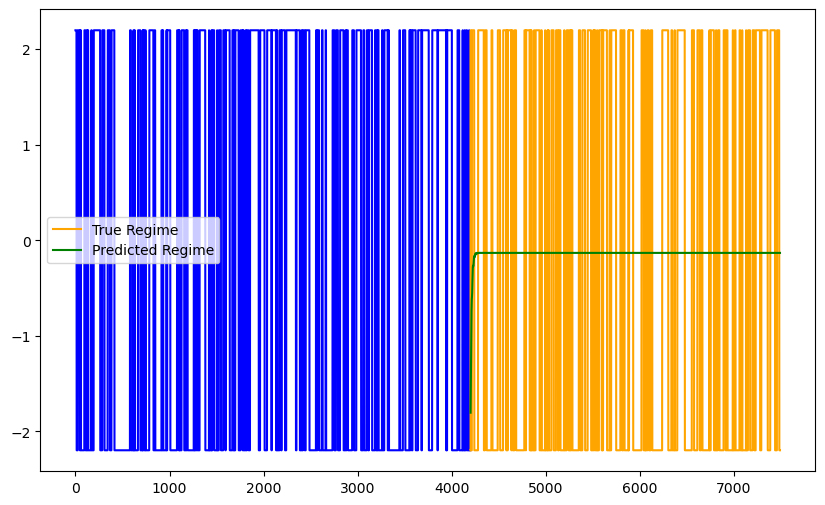

In [14]:
# Plot the chart for the best ARIMA model 

arima = ARIMA(endog=train_y.reset_index()['regime_logit'], order=(4,0,4))
model = arima.fit()
val_y.index = range(4200, 4200+len(val_y.index))
preds = model.predict(start=4200, end=7489, dynamic=False)

plt.figure(figsize=(10,6))
plt.plot(train_y.reset_index()['regime_logit'], color='blue')
plt.plot(val_y, color='orange', label='True Regime')
plt.plot(preds, color='green', label='Predicted Regime')
plt.legend();



# Chart y-axis are the logit values of each day's regime state

In [15]:
def logit_to_binary(preds):
    # convert logit values to sigmoid values between 0-1
    sigmoid_preds = expit(preds)
    # convert sigmoid values to binary values 0 or 1 (threshold =0.50)
    binary_preds = np.where(sigmoid_preds>=0.5, 1, 0)
    return binary_preds

In [16]:
# Convert train_y and train_preds from logit form back to binary form for plotting
train_y_actual = logit_to_binary(train_y)
train_y_preds = logit_to_binary(model.predict())

In [17]:
# Convert val_y and val_preds from logit form back to binary form for plotting
val_y_actual = logit_to_binary(val_y)
val_y_preds = logit_to_binary(preds)

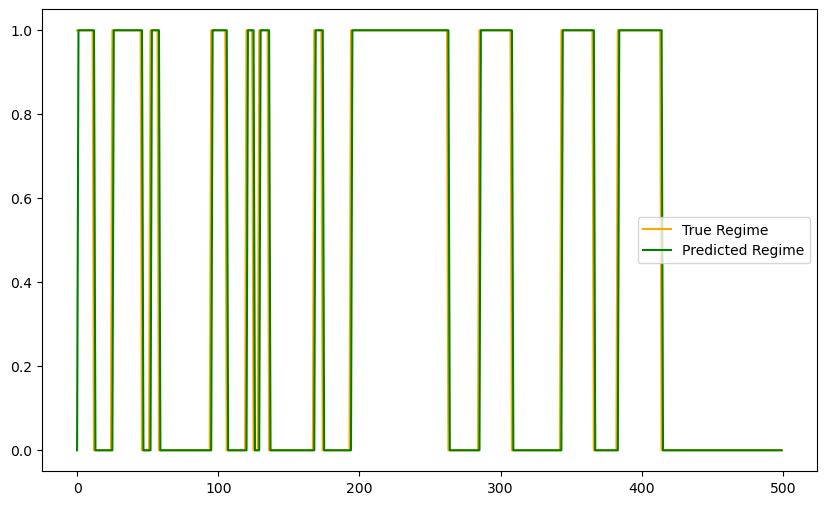

In [19]:
# Plot first 500 rows in the training period to check trained model's predictive performance

plt.figure(figsize=(10,6))
plt.plot(train_y_actual[:500], color='orange', label='True Regime')
plt.plot(train_y_preds[:500], color='green', label='Predicted Regime')
plt.legend()

# Predictions match the actual training target perfectly as expected

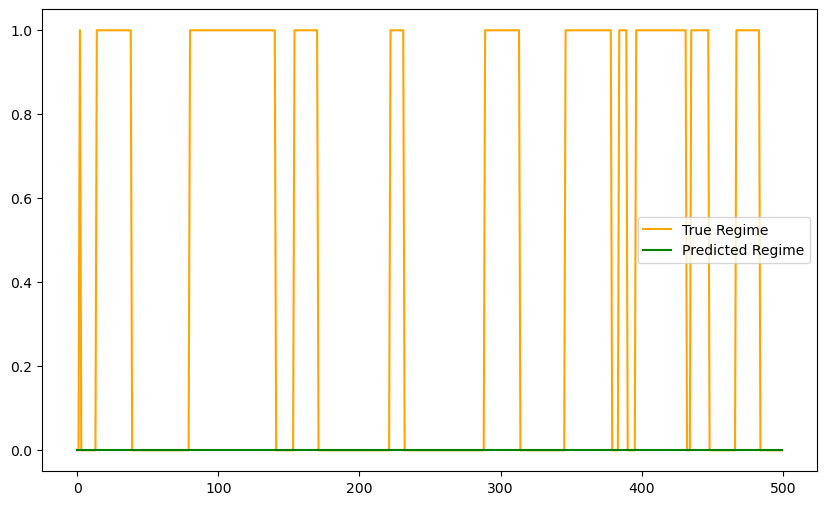

In [20]:
# Plot first 500 rows in the validation period to check trained model's predictive performance

plt.figure(figsize=(10,6))
plt.plot(val_y_actual[:500], color='orange', label='True Regime')
plt.plot(val_y_preds[:500], color='green', label='Predicted Regime')
plt.legend()

# Very bad ARIMA model forecasts after training period! Only correct for first 20 days!
# ARIMA is not effective for long-term forecasts so dont bother as it reverts to mean

# Seasonal ARIMA with eXogenous Regressors Modeling

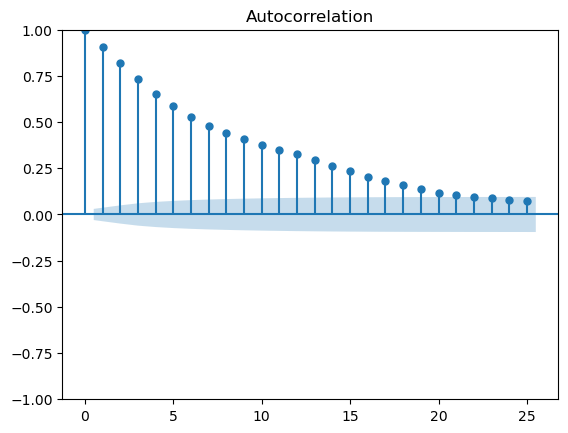

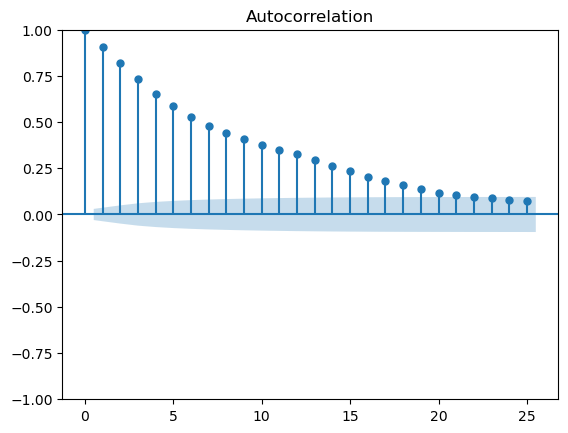

In [35]:
# Generate autocorrelation plot on training data
plot_acf(train_y, lags=25)

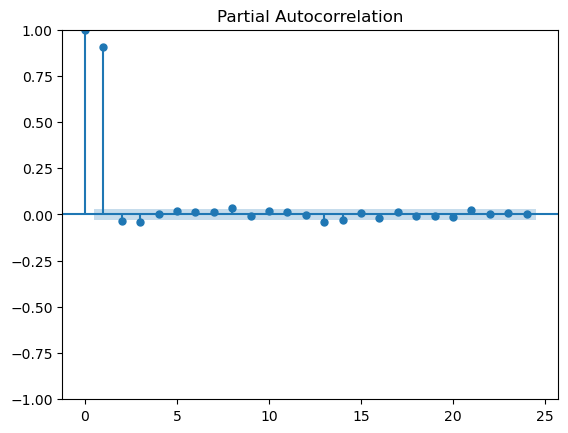

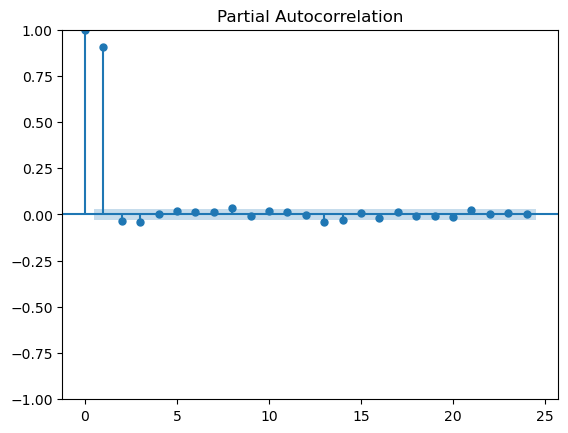

In [36]:
# Generate partial autocorrelation plot on training data
plot_pacf(train_y, lags=24, method='ywm')

In [37]:
# Splitting the dataset into train and test set using the split_index
train_X = asset[:split_index][['CCI', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']]
val_X = asset[split_index:][['CCI', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']]

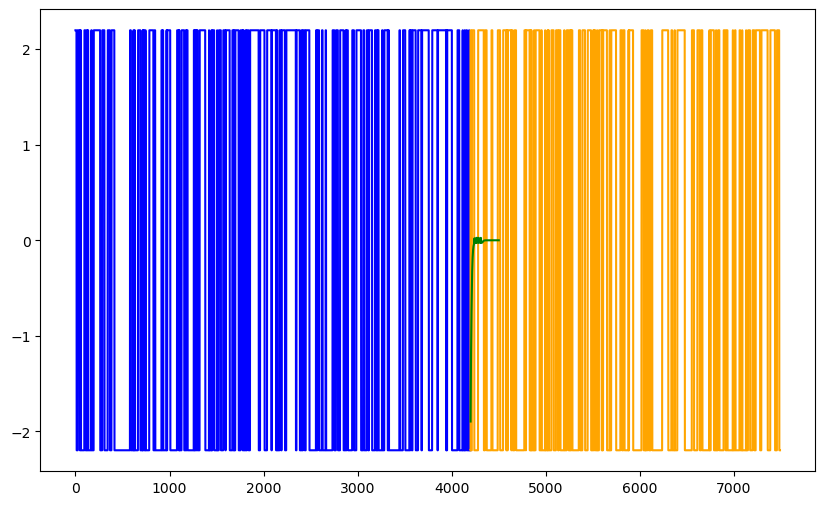

In [38]:
sarima = SARIMAX(endog=train_y.reset_index()['regime_logit'],
                order=(13,0,1),
                seasonal_order=(1,0,0,125))

sarima_model = sarima.fit(disp=0)

preds = sarima_model.predict(start=4200, end=4500)

val_y.index = range(4200, 4200+len(val_y.index))
plt.figure(figsize=(10,6))
plt.plot(train_y.reset_index()['regime_logit'], color='blue')
plt.plot(val_y, color='orange')
plt.plot(preds, color='green');

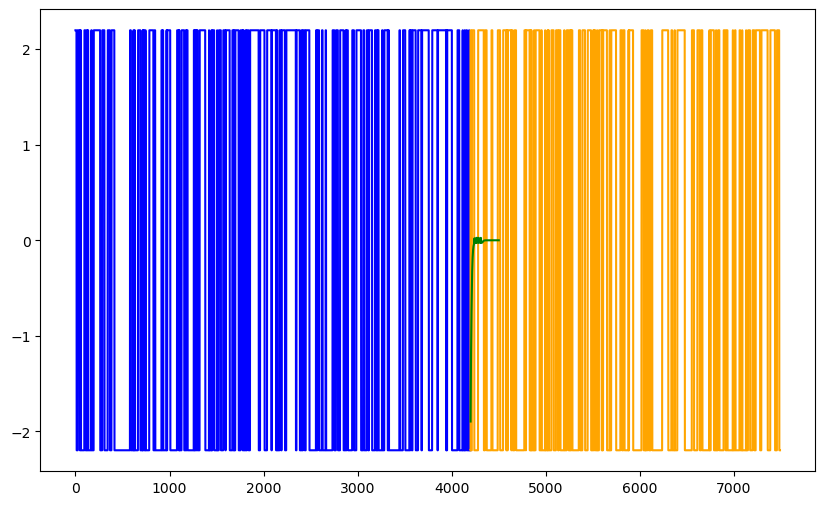

In [39]:
val_y.index = range(4200, 4200+len(val_y.index))
plt.figure(figsize=(10,6))
plt.plot(train_y.reset_index()['regime_logit'], color='blue')
plt.plot(val_y, color='orange')
plt.plot(preds, color='green');

In [40]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [41]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name, 
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [42]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window='boxcar',
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color='purple')
    ax.set_xscale("log")
    ax.set_xticks([1,2,4,6,12,26,52,104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
        )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='regime'>

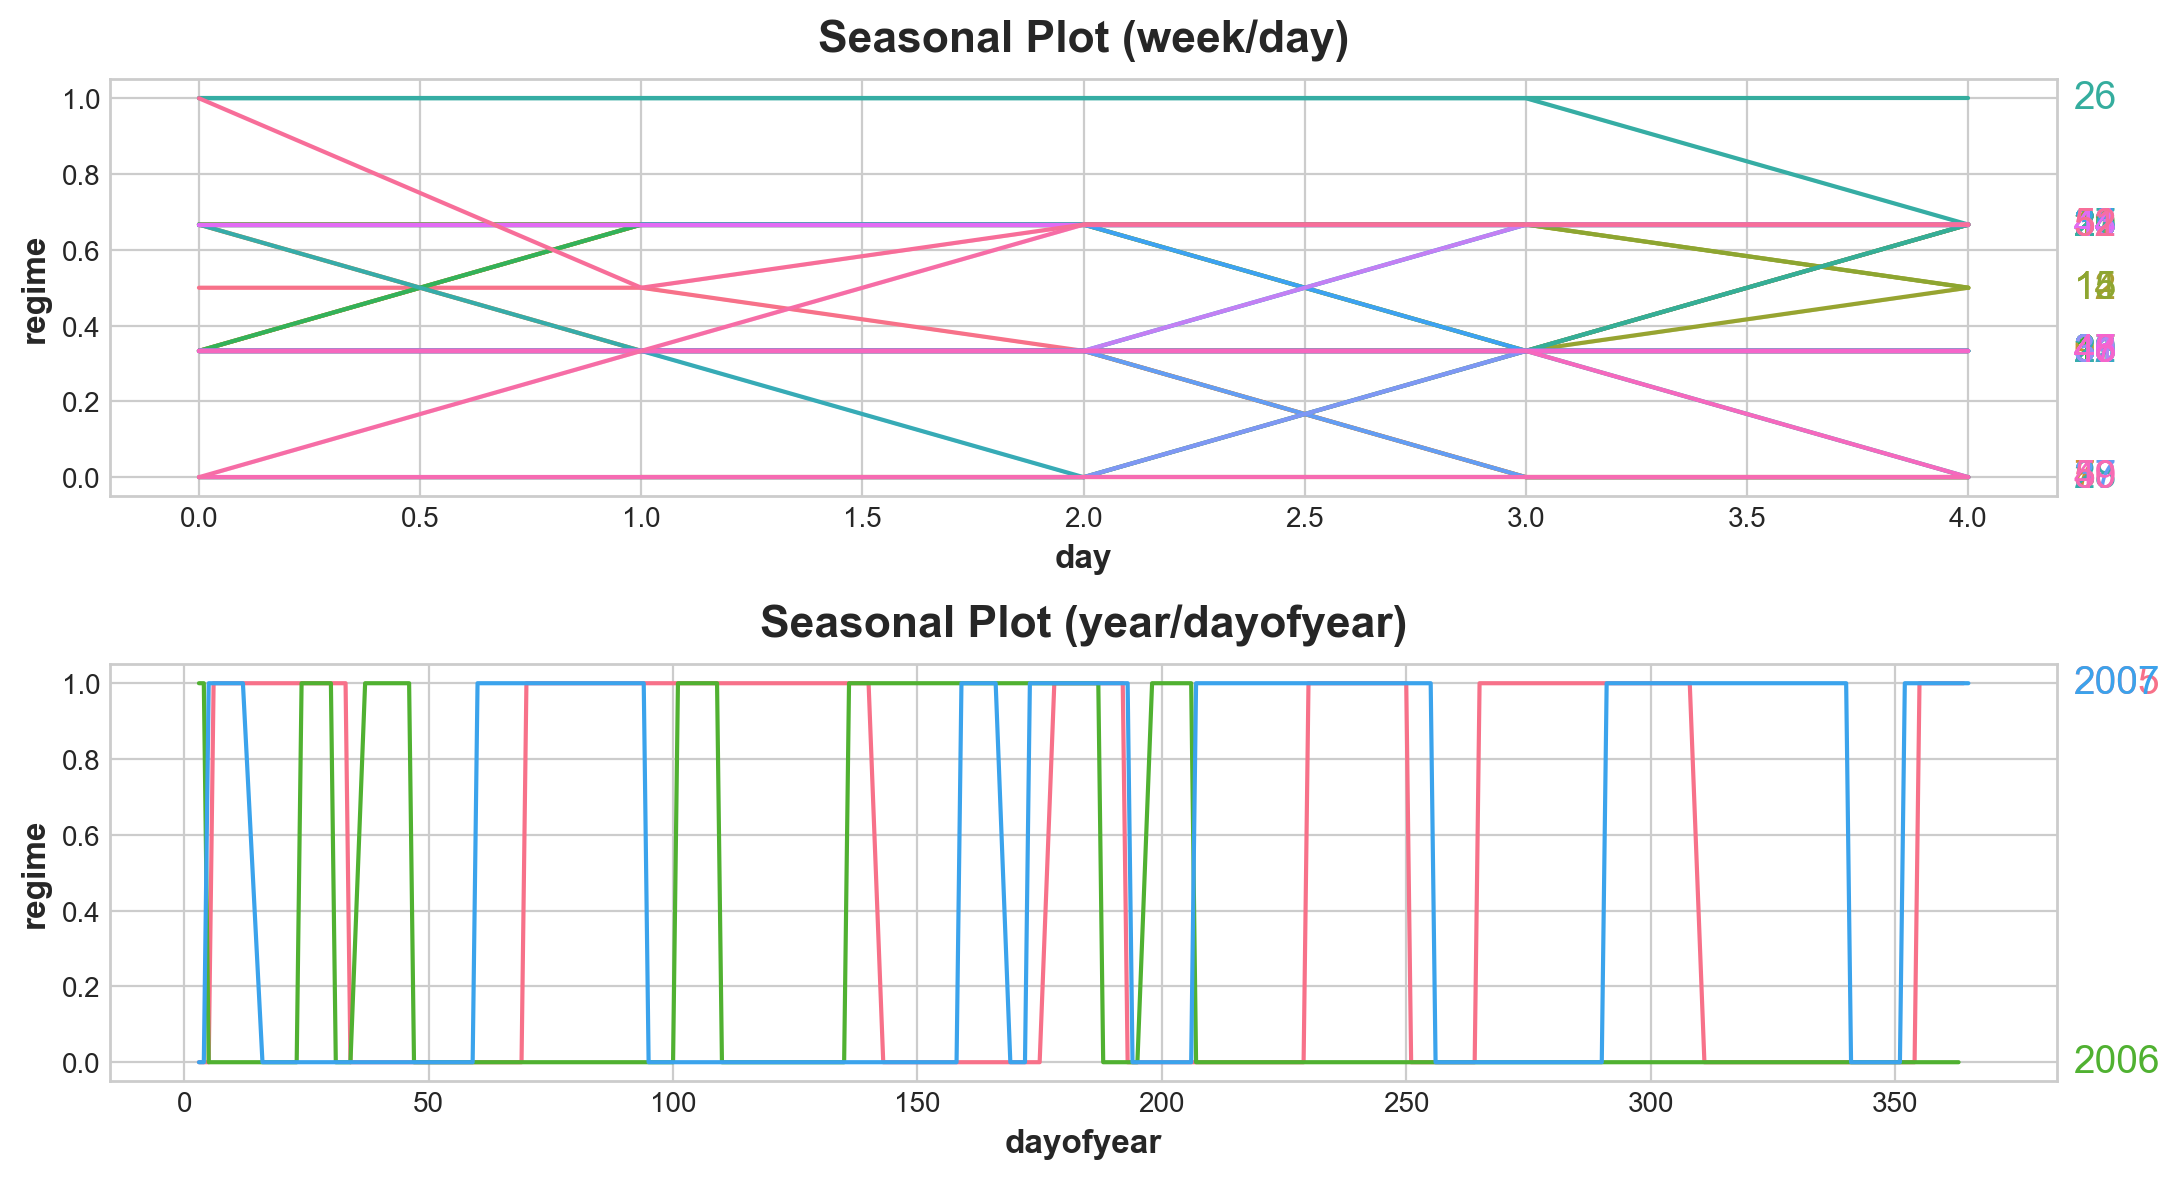

In [43]:
# days within a week
asset['day'] = asset.index.dayofweek
asset['week'] = asset.index.week

# days within a year
asset['dayofyear'] = asset.index.dayofyear
asset['year'] = asset.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11,6))
seasonal_plot(asset.loc['2005':'2007'], y='regime', period='week', freq='day', ax=ax0)
seasonal_plot(asset.loc['2005':'2007'], y='regime', period='year', freq='dayofyear', ax=ax1)

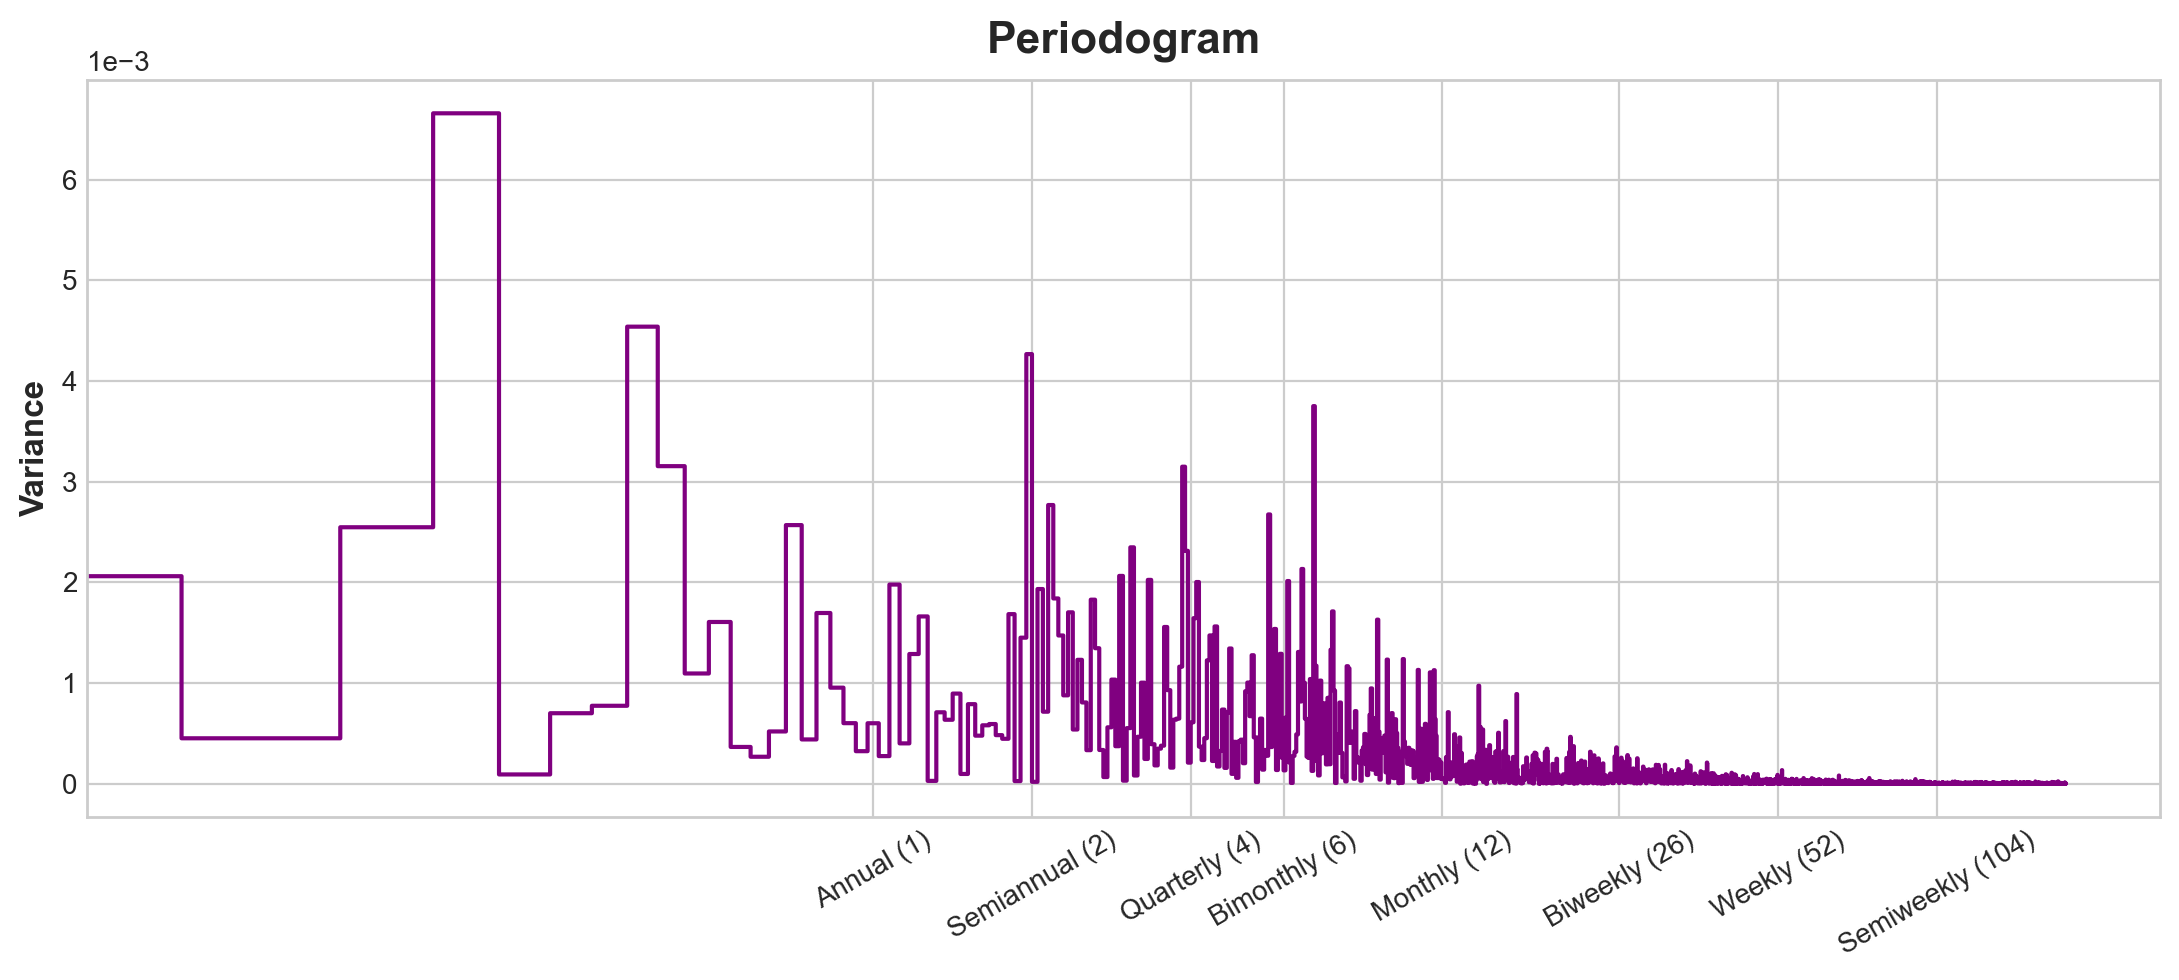

In [44]:
plot_periodogram(asset['regime']);

# There seems to be strong seasonality effects observed for the annual, semiannual, and bimonthly periods